# Result Reproducibility (CSIQ database evaluation)
You can reproduce our paper results following this notebook.

Please, first download the dataset and unzip it within this notebook folder.

The CSIQ dataset can be downloaded from [this link](https://s2.smu.edu/~eclarson/csiq.html)

also to run this code, libraries should be installed from `pip install -r requirements.txt`

### 1- Importing necessary libraries

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle

from similarity_metrics.fsim_quality import FSIMsimilarity
from similarity_metrics.issm_quality import ISSMsimilarity
from CopulaSimilarity.CSM import CopulaBasedSimilarity as CSMSimilarity
from image_similarity_measures.quality_metrics import ssim

### 2- Defining all similarity metrics and image loader

In [ ]:
class SimilarityMetrics:
    def __init__(self):
        # Initialize similarity objects
        self.fsim_similarity = FSIMsimilarity()
        self.issm_similarity = ISSMsimilarity()
        self.copula_similarity = CSMSimilarity()

    def compute_ssim(self, image_1, image_2):
        return ssim(image_1, image_2)

    def compute_fsim(self, image_1, image_2):
        return self.fsim_similarity.fsim(image_1, image_2)

    def compute_issm(self, image_1, image_2):
        return self.issm_similarity.issm(image_1, image_2)

    def compute_csm(self, image_1, image_2):
        csm = self.copula_similarity.compute_local_similarity(image_1, image_2)
        return np.mean(csm)

def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        print(f"Error loading image: {image_path}")
        return None
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

### 3- Loading CSIQ dataset

Depending on you hardward, this steps might take time to get complete. If you want to visualize the result without looping over the dataset, you can skip to next code cell.

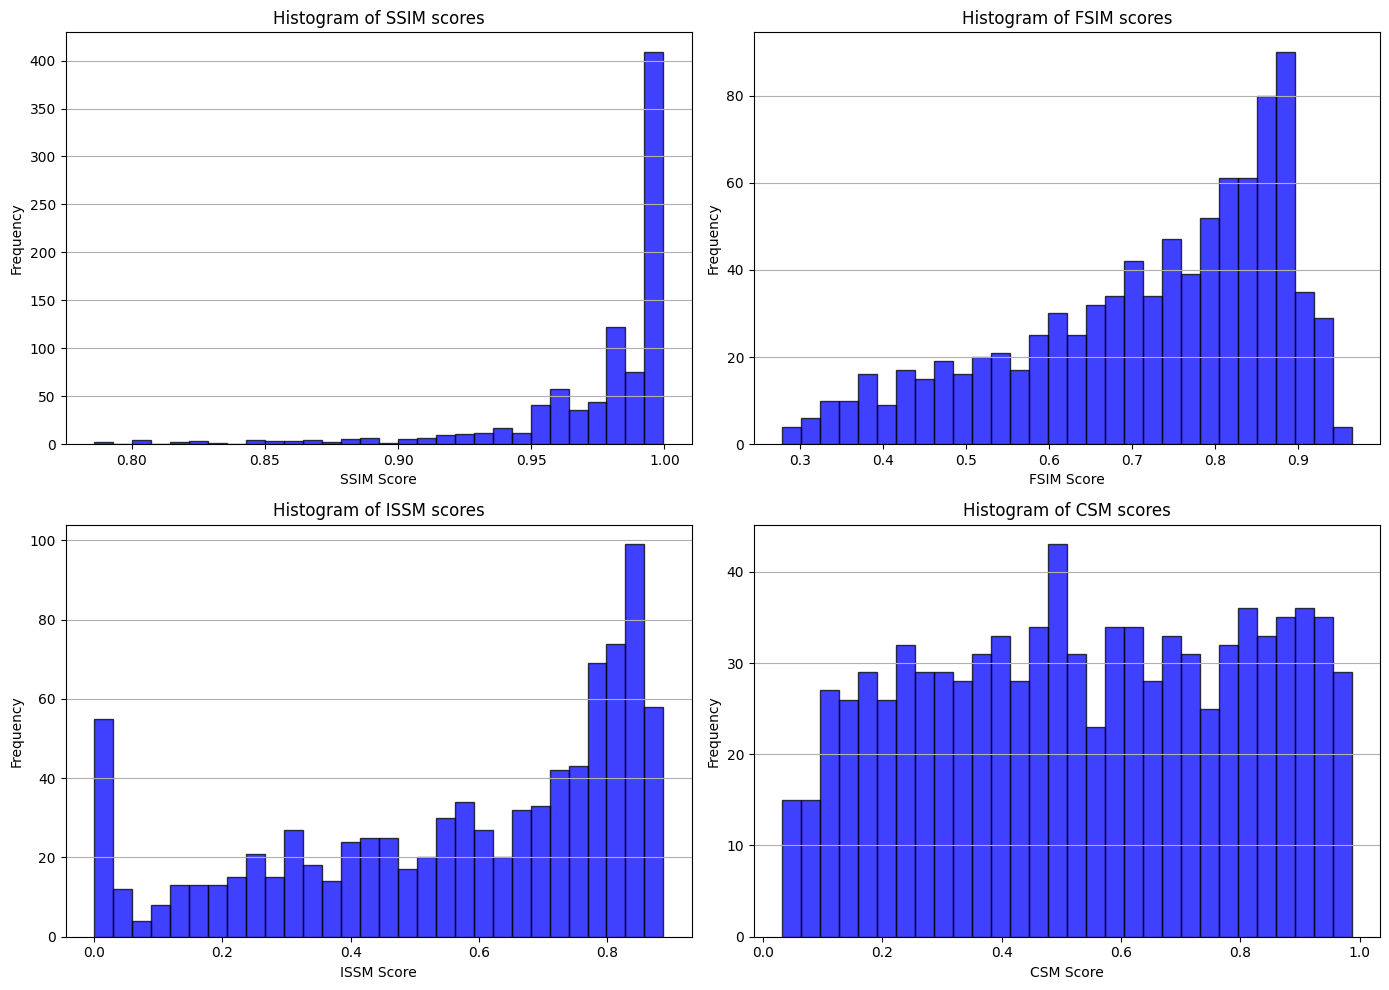

In [44]:
original_dir = 'dataset/original'
distorted_dir = 'dataset/distorted'

metrics = SimilarityMetrics()
similarity_scores = {'SSIM': [], 'FSIM': [], 'ISSM': [], 'CSM': [], 'distortion_type': []}

# Loop over each image in the original directory
for original_image_name in os.listdir(original_dir):
    original_image_path = os.path.join(original_dir, original_image_name)
    original_image = load_image(original_image_path)
    
    if original_image is None:
        continue
    
    # Loop over each distortion type
    for distortion_type in os.listdir(distorted_dir):
        distortion_path = os.path.join(distorted_dir, distortion_type)
        
        # Loop over each distorted image
        for distorted_image_name in os.listdir(distortion_path):
            if distorted_image_name.startswith(original_image_name.split('.')[0]):
                distorted_image_path = os.path.join(distortion_path, distorted_image_name)
                distorted_image = load_image(distorted_image_path)
                
                if distorted_image is None:
                    continue
                
                # Compute similarity metrics
                ssim_value = metrics.compute_ssim(original_image, distorted_image)
                fsim_value = metrics.compute_fsim(original_image, distorted_image)
                issm_value = metrics.compute_issm(original_image, distorted_image)
                csm_value = metrics.compute_csm(original_image, distorted_image)
                
                # Store the results
                similarity_scores['SSIM'].append(ssim_value)
                similarity_scores['FSIM'].append(fsim_value)
                similarity_scores['ISSM'].append(issm_value)
                similarity_scores['CSM'].append(csm_value)
                similarity_scores['distortion_type'].append(distortion_type)  # Store the distortion type

plt.figure(figsize=(14, 10))
for i, (metric_name, scores) in enumerate(similarity_scores.items(), 1):
    if metric_name != 'distortion_type':
        plt.subplot(2, 2, i)
        plt.hist(scores, bins=30, alpha=0.75, color='b', edgecolor='black')
        plt.title(f'Histogram of {metric_name} scores')
        plt.xlabel(f'{metric_name} Score')
        plt.ylabel('Frequency')
        plt.grid(axis='y')

plt.tight_layout()
plt.show()

# Store the results in a pickle file
with open('pkldata/similarity_scores_.pkl', 'wb') as f:
    pickle.dump(similarity_scores, f)


### 4- Visualize the results

You can run the following code cells without the need of previous cells. Make sure the path of the `similarity_scores.pkl` is correct (default `'pkldata/similarity_scores.pkl'`)

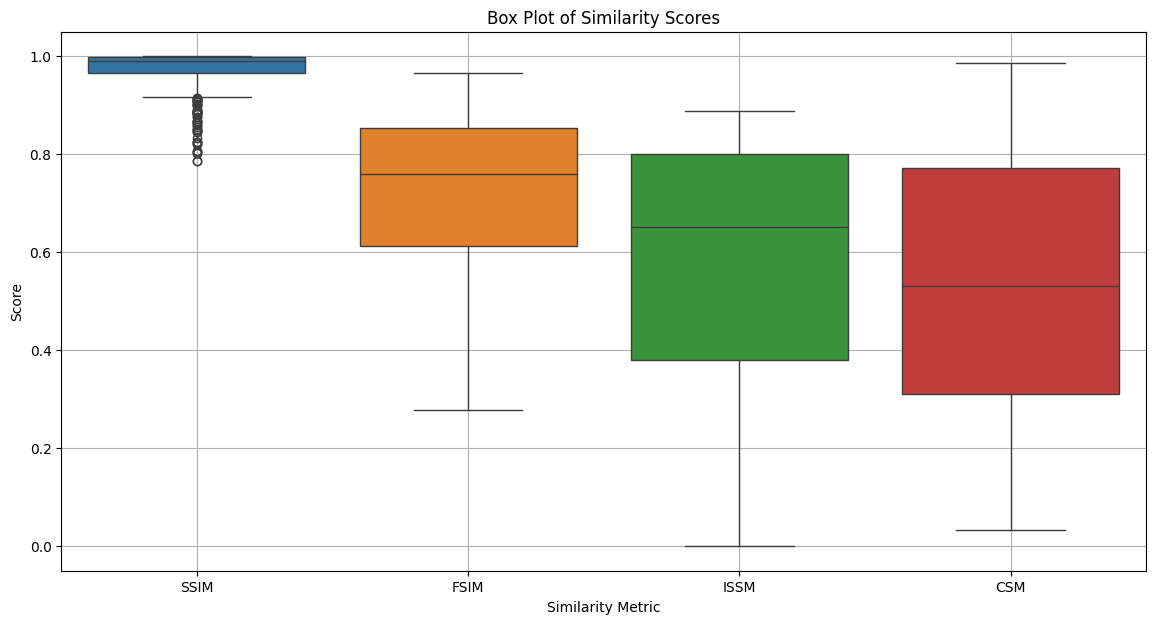

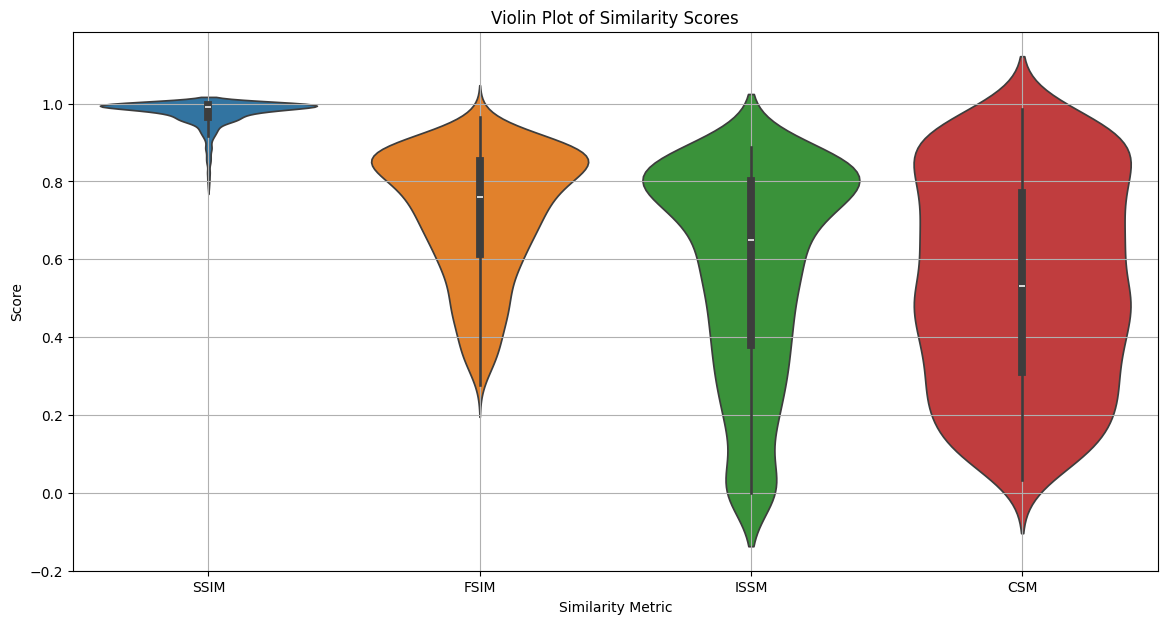

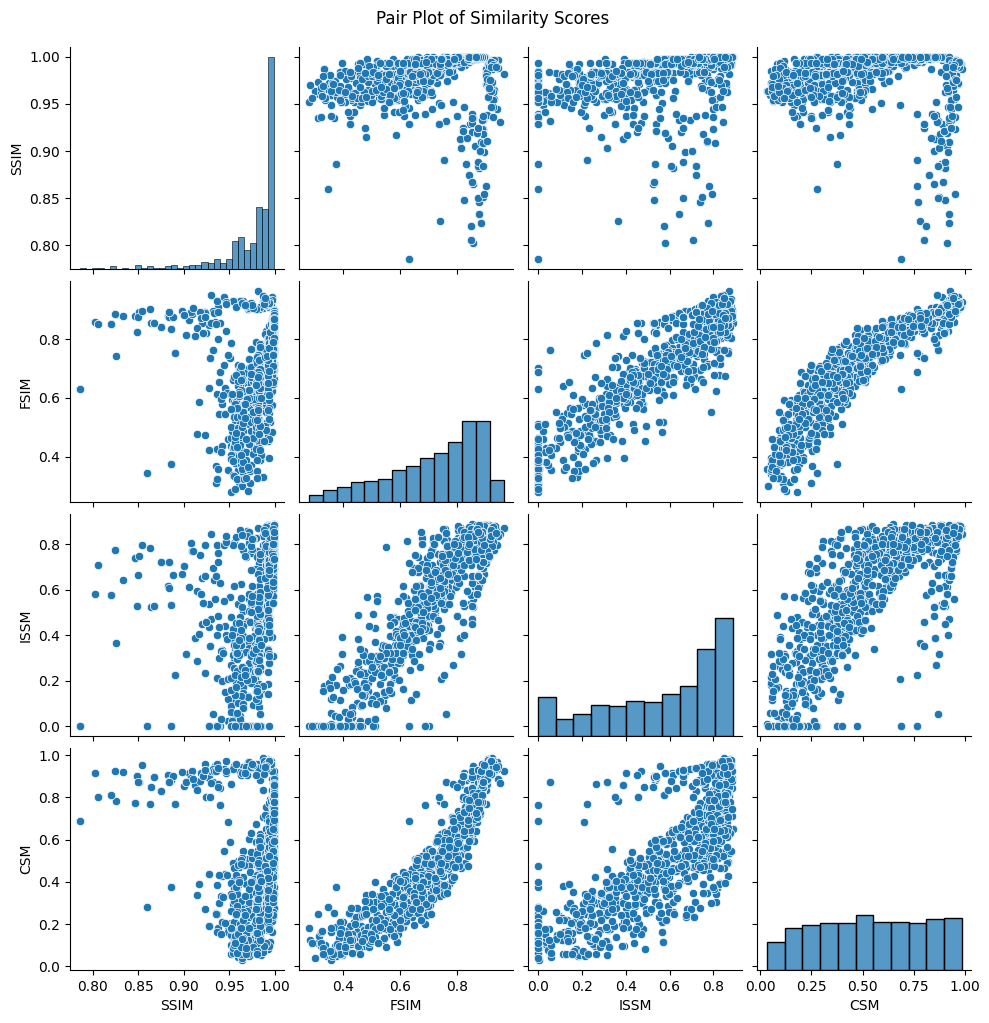

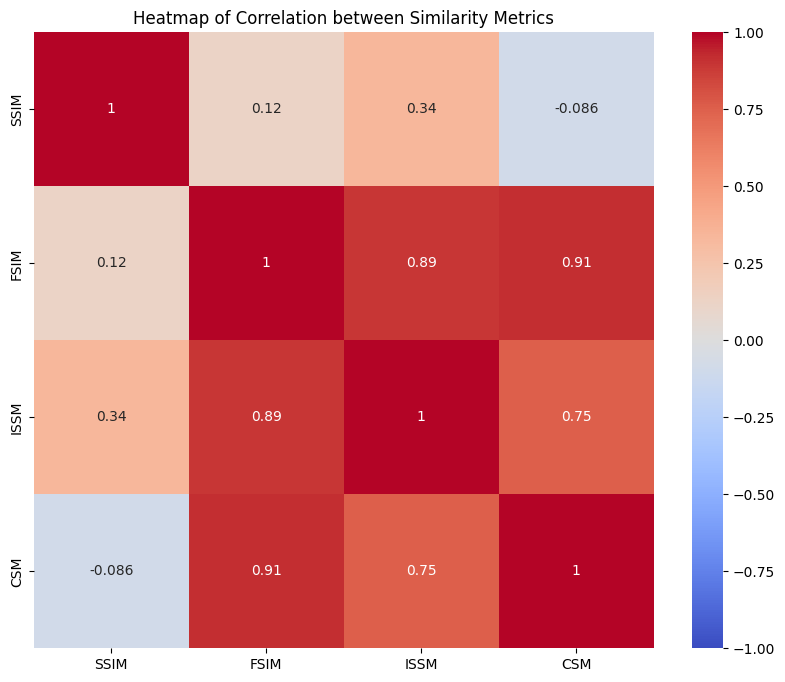

In [84]:
import pandas as pd
import seaborn as sns

with open('pkldata/similarity_scores.pkl', 'rb') as f:
    similarity_scores = pickle.load(f)

df = pd.DataFrame(similarity_scores)

# Plot box plots for each metric
plt.figure(figsize=(14, 7))
sns.boxplot(data=df)
plt.title('Box Plot of Similarity Scores')
plt.xlabel('Similarity Metric')
plt.ylabel('Score')
plt.grid(True)
plt.show()

# Plot violin plots for each metric
plt.figure(figsize=(14, 7))
sns.violinplot(data=df)
plt.title('Violin Plot of Similarity Scores')
plt.xlabel('Similarity Metric')
plt.ylabel('Score')
plt.grid(True)
plt.show()

# Plot pair plot to show scatter plots between metrics
sns.pairplot(df)
plt.suptitle('Pair Plot of Similarity Scores', y=1.02)
plt.show()

df_numerical = df.drop(columns=['distortion_type'])

# Generate a heatmap to show the correlation between different metrics
plt.figure(figsize=(10, 8))
sns.heatmap(df_numerical.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Correlation between Similarity Metrics')
plt.show()


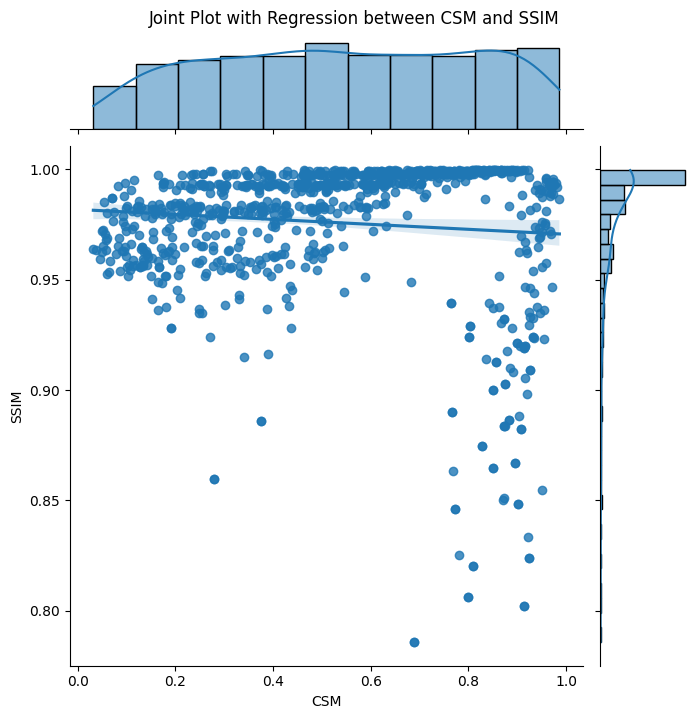

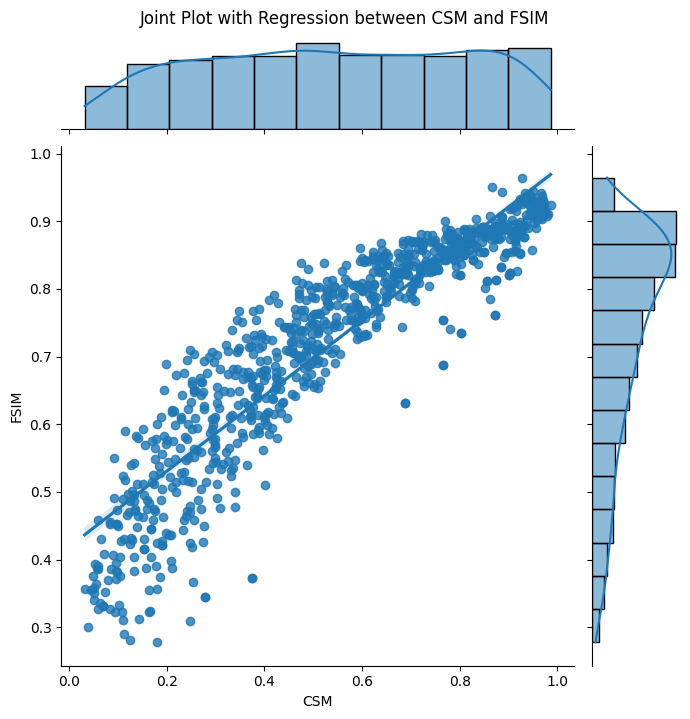

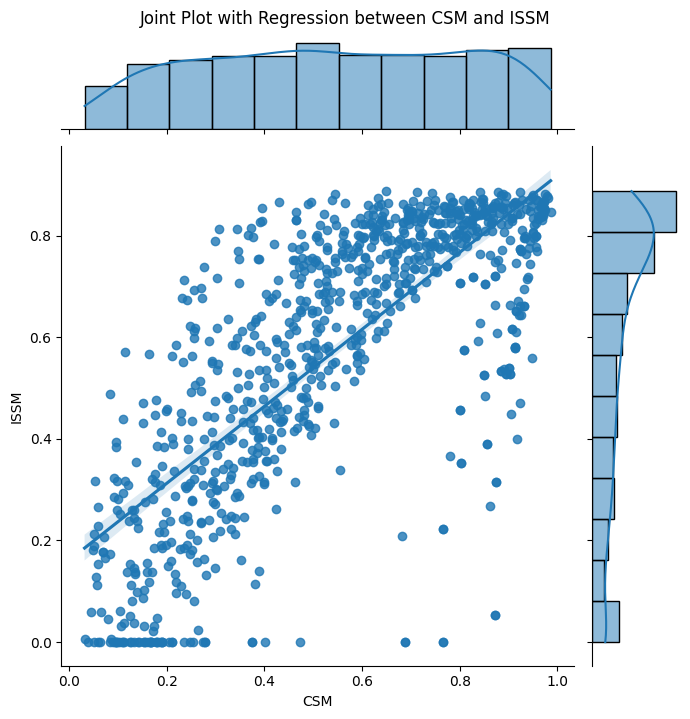

In [56]:
for col in df_numerical.columns:
    if col != 'CSM':
        sns.jointplot(data=df_numerical, x='CSM', y=col, kind='reg', height=7, ratio=5)
        plt.suptitle(f'Joint Plot with Regression between CSM and {col}', y=1.02)
        plt.show()

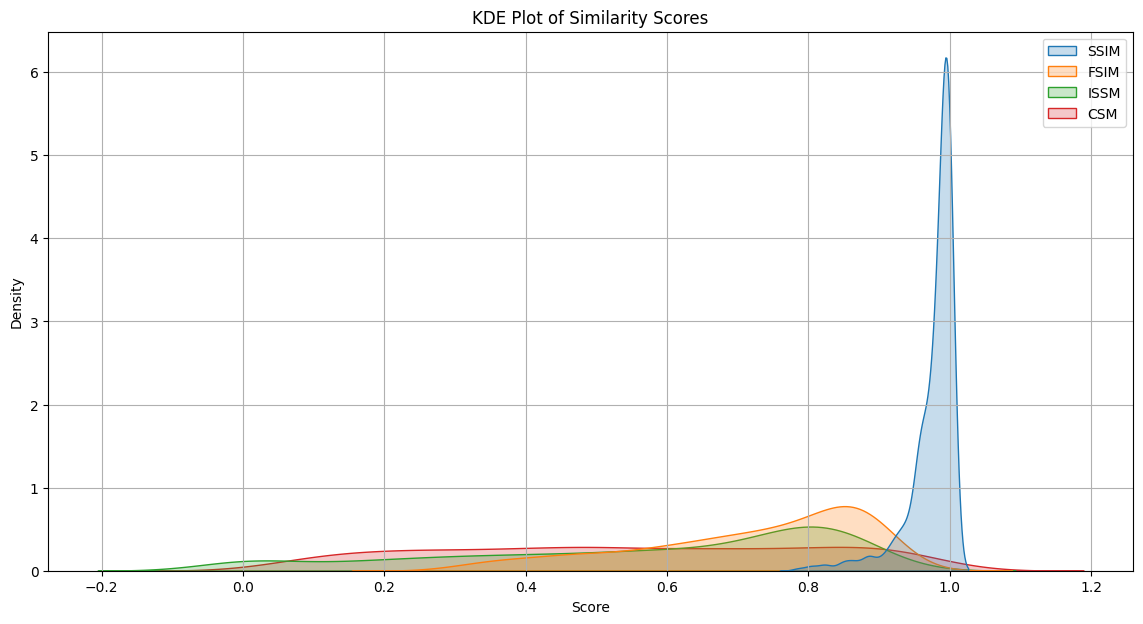

In [50]:
# KDE Plot
plt.figure(figsize=(14, 7))
sns.kdeplot(data=df, fill=True)
plt.title('KDE Plot of Similarity Scores')
plt.xlabel('Score')
plt.ylabel('Density')
plt.grid(True)
plt.show()


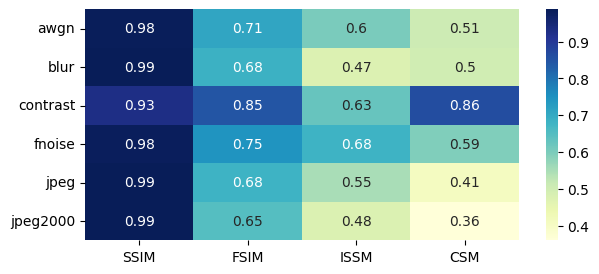

In [104]:
average_scores = df.groupby('distortion_type').mean()
plt.figure(figsize=(7, 3))
sns.heatmap(average_scores, annot=True, cmap='YlGnBu')
plt.ylabel('')
plt.savefig('heatmap_average_scores.pdf', format='pdf')
plt.show()

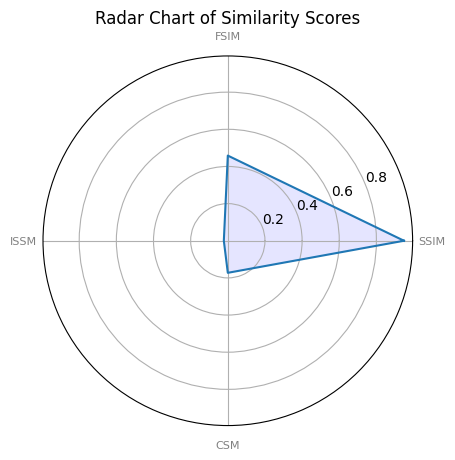

In [34]:
from math import pi

# Radar Chart
categories = list(df.columns)
N = len(categories)

values = df.loc[0].values.flatten().tolist()  # Taking the first row as an example
values += values[:1]  # Completing the loop

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], categories, color='grey', size=8)
ax.plot(angles, values)
ax.fill(angles, values, 'b', alpha=0.1)
plt.title('Radar Chart of Similarity Scores')
plt.show()


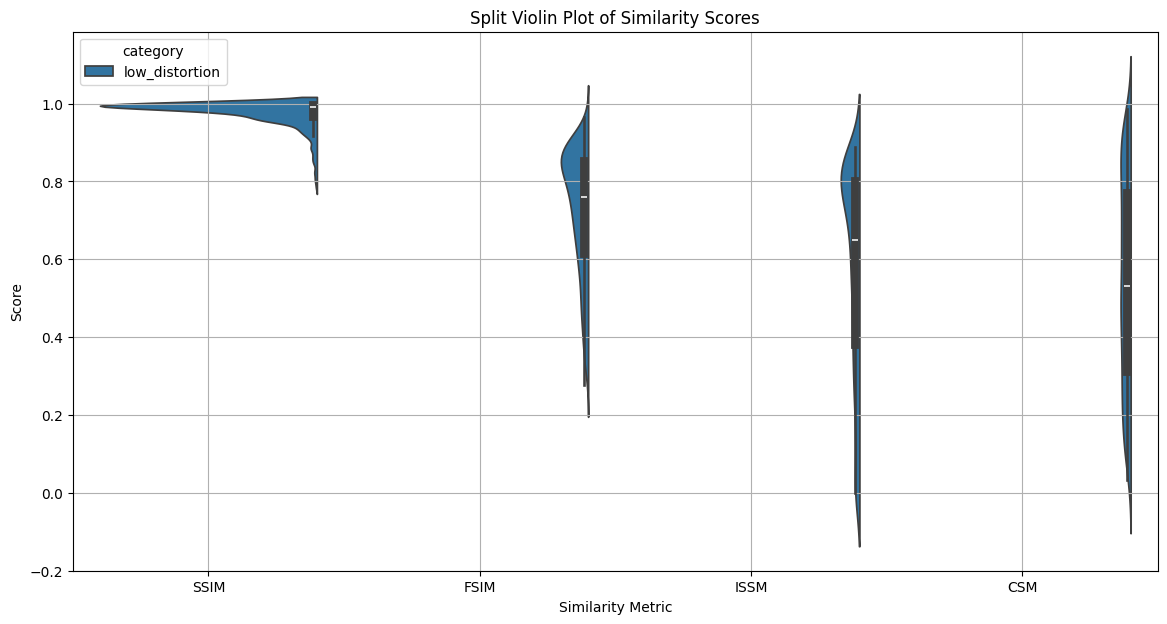

In [39]:
# Violin Plot with Split (useful if comparing two categories)
# Assuming you create two categories 'high_distortion' and 'low_distortion' based on some criteria
df['category'] = df['SSIM'].apply(lambda x: 'high_distortion' if x < 0.5 else 'low_distortion')

plt.figure(figsize=(14, 7))
sns.violinplot(x='variable', y='value', hue='category', data=pd.melt(df, id_vars='category'), split=True)
plt.title('Split Violin Plot of Similarity Scores')
plt.xlabel('Similarity Metric')
plt.ylabel('Score')
plt.grid(True)
plt.show()


<Figure size 3000x3000 with 0 Axes>

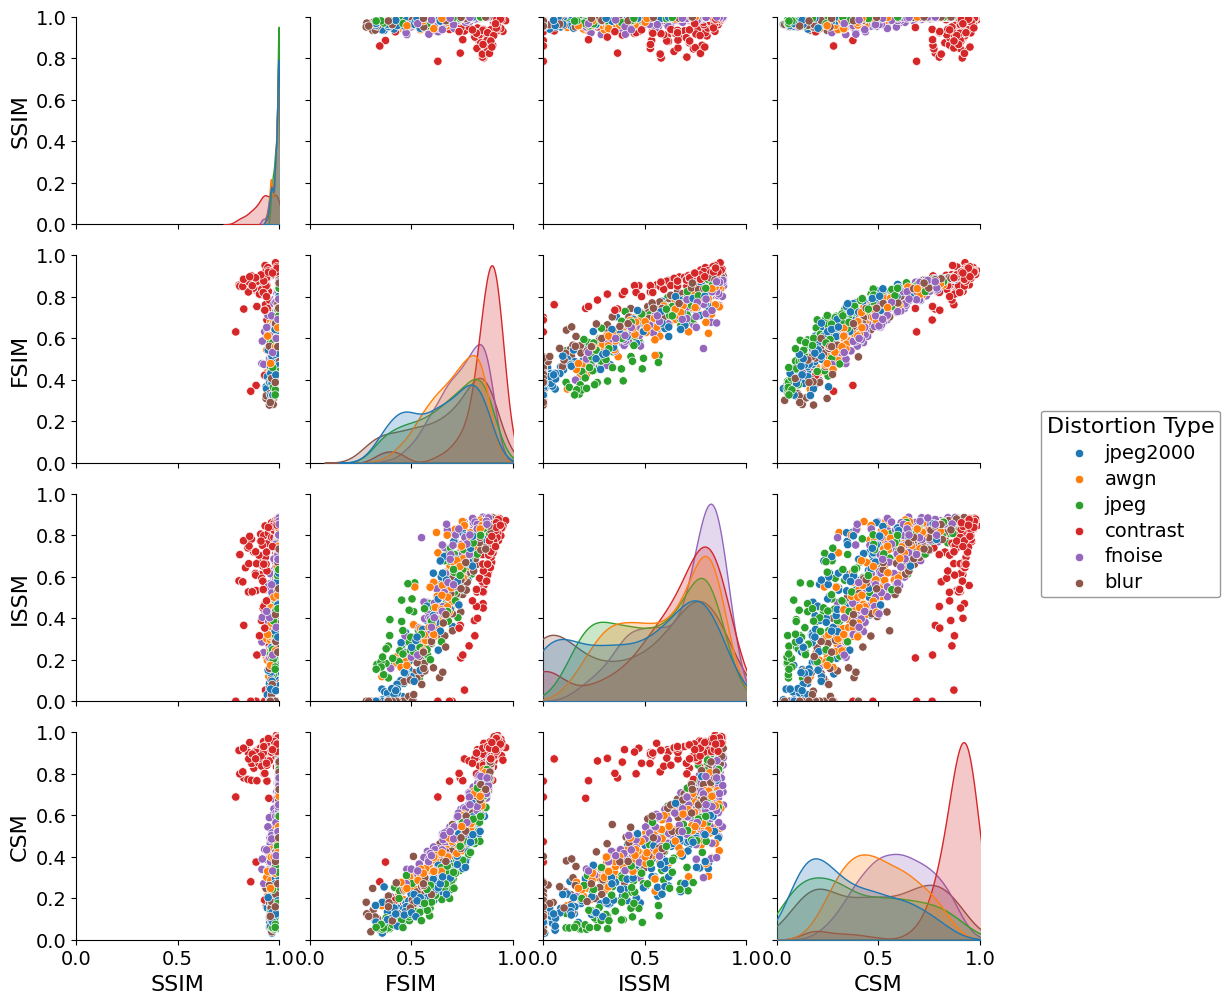

In [103]:
# Pair Plot Facet Grid by Distortion Type
plt.figure(figsize=(30, 30))  # Set figure size to 30x30
g = sns.pairplot(df, hue='distortion_type', height=2.5)

# Adjust the x and y limits for each subplot
for ax in g.axes.flat:
    ax.set_ylim(0, 1)  # Set ylim to 0 to 1
    ax.set_xlim(0, 1)  # Set xlim to 0 to 1
    ax.tick_params(axis='both', labelsize=14)  # Increase tick label size
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)  # Increase x-axis label size
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)  # Increase y-axis label size

# Increase legend text size
g._legend.set_title('Distortion Type', prop={'size': 16})
for label in g._legend.get_texts():
    label.set_fontsize(14)

# Move the legend to the left and add a grey border with transparent background
g._legend.set_bbox_to_anchor((1.1, 0.5))  # Move the legend to the left
g._legend.set_frame_on(True)  # Add a frame around the legend
g._legend.get_frame().set_facecolor('none')  # Set the background to transparent
g._legend.get_frame().set_edgecolor('grey')  # Set the border to grey

plt.subplots_adjust(wspace=0.15, hspace=0.15)

plt.savefig('similarity_scores_by_distortion_type.pdf', format='pdf', bbox_inches='tight')

plt.show()